In [33]:
#1# Mandatory libraries: 
import pandas as pd
import warnings
import numpy as np
from preprocessing import *


#2# Time-series:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

RSEED = 5

In [34]:
#3# Data visualization: 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

#3A# Plot formatting:
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': 'white', 'grid.color': '.8'}
)
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'
cmaps_hex = ['#193251','#FF5A36','#696969', '#7589A2','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [35]:
df = pd.read_csv("data/AQUASTAT_complete.csv", index_col=0)

In [36]:
pre_split_processor = get_pre_split_processor()
df_pre = pre_split_processor.transform(df)
df_pre['year'] = pd.to_datetime(df_pre['year'], format='%Y') 

df_pre.set_index('year', inplace=True)

In [37]:
df_pre.head()

,country,%_of_agricultural_gva_produced_by_irrigated_agriculture,%_of_agricultural_water_managed_area_equipped_for_irrigation,%_of_total_country_area_cultivated,agricultural_water_withdrawal,agricultural_water_withdrawal_as_%_of_total_renewable_water_resources,agricultural_water_withdrawal_as_%_of_total_water_withdrawal,agriculture_value_added_%_gdp,cultivated_area_arable_land_plus_permanent_crops,dam_capacity_per_capita,...,total_internal_renewable_water_resources,total_internal_renewable_water_resources_per_capita,total_population,total_population_with_access_to_safe_drinking_water,total_renewable_groundwater,total_renewable_water_resources_per_capita,total_water_withdrawal,total_water_withdrawal_per_capita,urban_population,water_resources_total_external_renewable
year,,,,,,,,,,,,,,,,,,,,,
1964-01-01,Afghanistan,NaN,NaN,12.059247,NaN,NaN,NaN,NaN,7873.0,123.142839,...,47.15,4838.487391,9744.781,NaN,10.65,6704.101406,NaN,NaN,932.865,18.18
1965-01-01,Afghanistan,NaN,NaN,12.062310,NaN,NaN,NaN,NaN,7875.0,120.526460,...,47.15,4735.685474,9956.320,NaN,10.65,6561.661337,NaN,NaN,984.350,18.18
1966-01-01,Afghanistan,NaN,NaN,12.120516,NaN,NaN,NaN,NaN,7913.0,117.938019,...,47.15,4633.981324,10174.836,NaN,10.65,6420.742310,NaN,NaN,1038.852,18.18
1967-01-01,Afghanistan,NaN,100.0,12.221610,NaN,NaN,NaN,NaN,7979.0,140.289460,...,47.15,4533.686105,10399.926,NaN,10.65,6281.775466,NaN,NaN,1096.428,18.18
1968-01-01,Afghanistan,NaN,100.0,12.223141,NaN,NaN,NaN,NaN,7980.0,188.867923,...,47.15,4432.614529,10637.063,NaN,10.65,6141.732920,NaN,NaN,1157.827,18.18


In [38]:
#targets = ['gdp_per_capita', 'water_stress', 'total_population_with_access_to_safe_drinking_water']

- Choosing one country to work with:

In [39]:
#Checking null values:
df_brasil = df_pre.query("country=='Brazil'")
df_brasil.isna().sum()

country                                                                   0
%_of_agricultural_gva_produced_by_irrigated_agriculture                  25
%_of_agricultural_water_managed_area_equipped_for_irrigation             34
%_of_total_country_area_cultivated                                        0
agricultural_water_withdrawal                                            32
agricultural_water_withdrawal_as_%_of_total_renewable_water_resources    32
agricultural_water_withdrawal_as_%_of_total_water_withdrawal             32
agriculture_value_added_%_gdp                                             0
cultivated_area_arable_land_plus_permanent_crops                          0
dam_capacity_per_capita                                                   0
dependency_ratio                                                          0
gdp_per_capita                                                            6
groundwater_accounted_inflow                                              0
groundwater_

In [40]:
df_br_no_coun = df_brasil.drop("country", axis=1)
mean_value = df_br_no_coun.mean()
df_brasil.fillna(mean_value, inplace=True)
df_br_no_coun.fillna(mean_value, inplace=True)

df_brasil.isna().sum()


C:\Users\david\AppData\Local\Temp\ipykernel_27076\1319396455.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_brasil.fillna(mean_value, inplace=True)


country                                                                  0
%_of_agricultural_gva_produced_by_irrigated_agriculture                  0
%_of_agricultural_water_managed_area_equipped_for_irrigation             0
%_of_total_country_area_cultivated                                       0
agricultural_water_withdrawal                                            0
agricultural_water_withdrawal_as_%_of_total_renewable_water_resources    0
agricultural_water_withdrawal_as_%_of_total_water_withdrawal             0
agriculture_value_added_%_gdp                                            0
cultivated_area_arable_land_plus_permanent_crops                         0
dam_capacity_per_capita                                                  0
dependency_ratio                                                         0
gdp_per_capita                                                           0
groundwater_accounted_inflow                                             0
groundwater_entering_the_

- Checking target seasonality for Brasil: 

Text(0, 0.5, 'Population with access to safe drinking water')

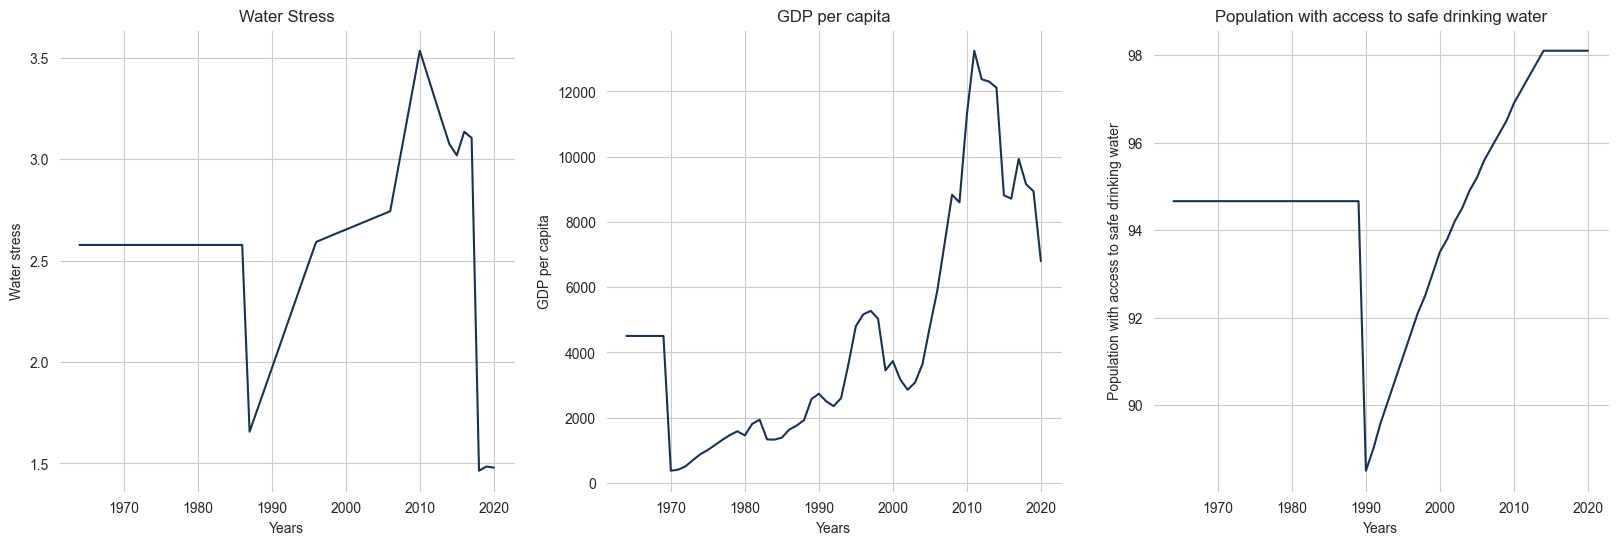

In [41]:
fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
ax1,ax2,ax3 = ax

sns.lineplot(x= df_brasil.index, y=df_brasil['water_stress'], ax=ax1)
ax1.set_title('Water Stress')
ax1.set_xlabel('Years')
ax1.set_ylabel('Water stress')

sns.lineplot(x=df_brasil.index, y=df_brasil['gdp_per_capita'], ax=ax2)
ax2.set_title('GDP per capita')
ax2.set_xlabel('Years')
ax2.set_ylabel('GDP per capita')

sns.lineplot(x=df_brasil.index, y=df_brasil['total_population_with_access_to_safe_drinking_water'], ax=ax3)
ax3.set_title('Population with access to safe drinking water')
ax3.set_xlabel('Years')
ax3.set_ylabel('Population with access to safe drinking water')

#fig.savefig("visualisations/time_plot_for_all_targets_br.png",dpi=300)

In [46]:
br_season_no_period_water_stress = seasonal_decompose(df_brasil["water_stress"], model='additive')
br_season_no_period_gdp = seasonal_decompose(df_brasil["gdp_per_capita"], model='additive')
br_season_no_period_save_water = seasonal_decompose(df_brasil["total_population_with_access_to_safe_drinking_water"], model='additive')

br_season_period_10_water_stress = seasonal_decompose(df_brasil["water_stress"], model='additive',period=10)
br_season_period_10_gdp = seasonal_decompose(df_brasil["gdp_per_capita"], model='additive',period=10)
br_season_period_10_save_water = seasonal_decompose(df_brasil["total_population_with_access_to_safe_drinking_water"], model='additive',period=10)

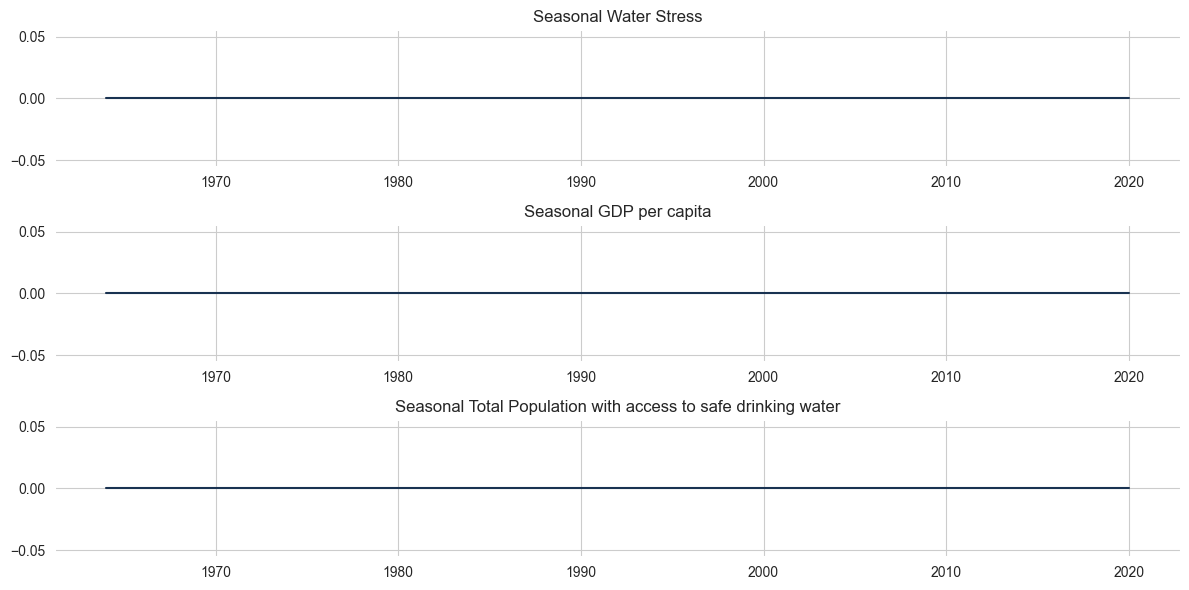

In [48]:
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(br_season_no_period_water_stress.seasonal)
plt.title("Seasonal Water Stress")

plt.subplot(3, 1, 2) 
plt.plot(br_season_no_period_gdp.seasonal)
plt.title("Seasonal GDP per capita")

plt.subplot(3, 1, 3) 
plt.plot(br_season_no_period_save_water.seasonal)
plt.title("Seasonal Total Population with access to safe drinking water")

plt.tight_layout() 
plt.show()

fig.savefig("visualisations/seasonality_for_all_targets_simple_no_period.png",dpi=300)

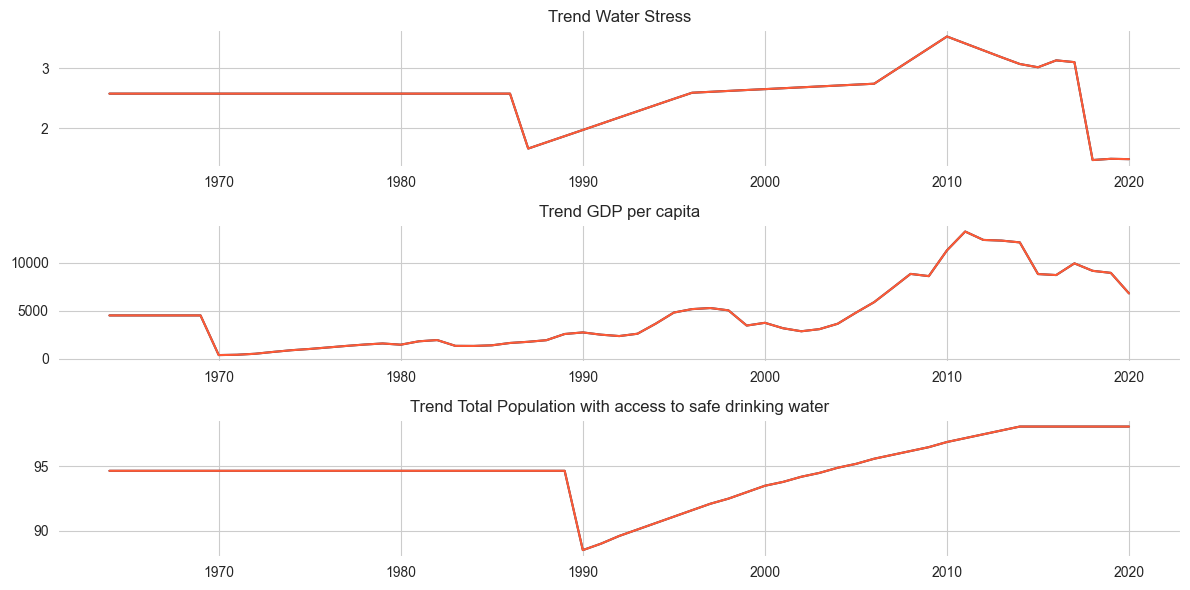

In [55]:
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(br_season_no_period_water_stress.trend)
plt.plot(df_brasil['water_stress'])
plt.title("Trend Water Stress")

plt.subplot(3, 1, 2) 
plt.plot(br_season_no_period_gdp.trend)
plt.plot(df_brasil['gdp_per_capita'])
plt.title("Trend GDP per capita")

plt.subplot(3, 1, 3) 
plt.plot(br_season_no_period_save_water.trend)
plt.plot(df_brasil['total_population_with_access_to_safe_drinking_water'])
plt.title("Trend Total Population with access to safe drinking water")

plt.tight_layout() 
plt.show()

fig.savefig("visualisations/trend_for_all_targets_simple_no_period.png",dpi=300)

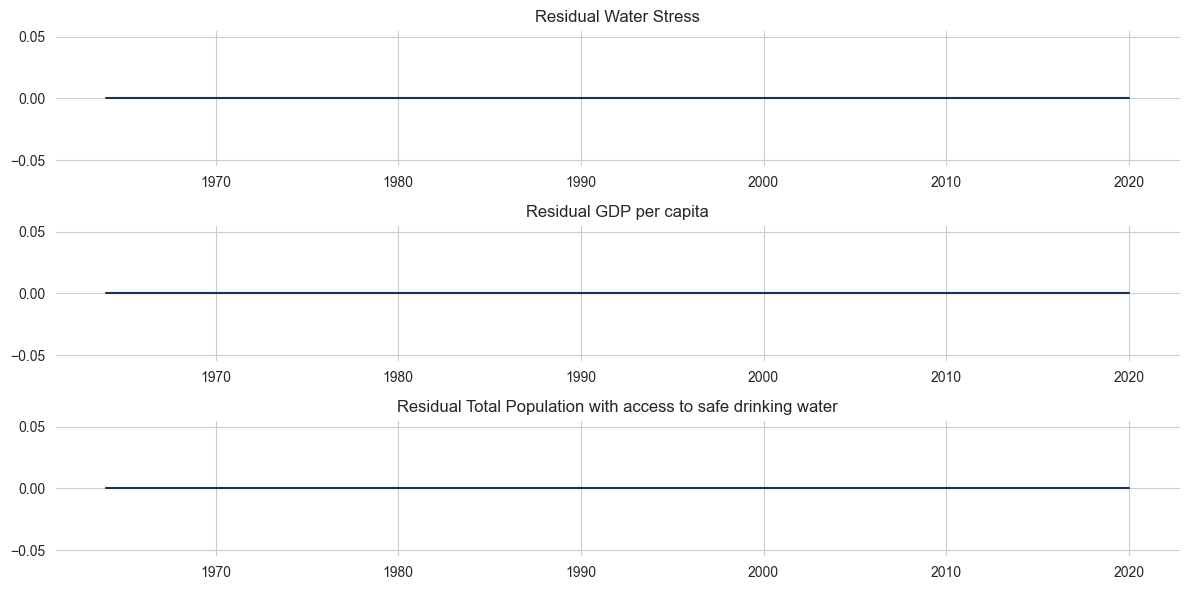

In [52]:
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(br_season_no_period_water_stress.resid)
plt.title("Residual Water Stress")

plt.subplot(3, 1, 2) 
plt.plot(br_season_no_period_gdp.resid)
plt.title("Residual GDP per capita")

plt.subplot(3, 1, 3) 
plt.plot(br_season_no_period_save_water.resid)
plt.title("Residual Total Population with access to safe drinking water")

plt.tight_layout() 
plt.show()

fig.savefig("visualisations/residual_for_all_targets_simple_no_period.png",dpi=300)

- Check for stationarity

In [56]:
# Check for stationarity (Dickey-Fuller test):

def check_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'{key}: {value}')

print("Water Stress:")
check_stationarity(df_brasil['water_stress'])
print("  ")
print("GDP per capita:")
check_stationarity(df_brasil['gdp_per_capita'])
print("  ")
print("Total Population with access to safe drinking water:")
check_stationarity(df_brasil['total_population_with_access_to_safe_drinking_water'])

Water Stress:
ADF Statistic: -1.5835402292569394
p-value: 0.49185631626041626
Critical Values:
1%: -3.552928203580539
5%: -2.9147306250000002
10%: -2.595137155612245
  
GDP per capita:
ADF Statistic: -1.481219475838645
p-value: 0.5427804971430175
Critical Values:
1%: -3.5656240522121956
5%: -2.920142229157715
10%: -2.598014675124952
  
Total Population with access to safe drinking water:
ADF Statistic: -1.0209521167151807
p-value: 0.7455460029055919
Critical Values:
1%: -3.552928203580539
5%: -2.9147306250000002
10%: -2.595137155612245


In [ ]:
print(f"Water Stress nan: {df_brasil['water_stress'].isna().sum()}")
print(f"GDP per capita nan: {df_brasil['gdp_per_capita'].isna().sum()}")
print(f"Total Population with access to safe drinking water nan: {df_brasil['total_population_with_access_to_safe_drinking_water'].isna().sum()}", "\n")